In [35]:
import torchfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from imageio import imread
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, sampler
from skimage.transform import pyramid_gaussian

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [5]:
def evaluate_loss(model, data, labels, loss_fn):
    """
    evaluate the loss
    """
    predicted = model(data)
    errors = loss_fn(predicted, labels)
    return float(errors)


def plot_loss(train_loss_lst, val_loss_lst, title):
    plt.plot(np.arange(len(train_loss_lst)), train_loss_lst, color='k', label='train')
    plt.plot(np.arange(len(val_loss_lst)), val_loss_lst, color='g', label='validation')
    plt.legend()
    plt.title(title)
    plt.xlabel('epoch[#]')
    plt.ylabel('loss')
    plt.show()
  
def save_plot(name, train_loss_lst, val_loss_lst, title):
    plt.plot(np.arange(len(train_loss_lst)), train_loss_lst, color='k', label='train')
    plt.plot(np.arange(len(val_loss_lst)), val_loss_lst, color='g', label='validation')
    plt.legend()
    plt.title(title)
    plt.xlabel('epoch[#]')
    plt.ylabel('loss')
    plt.savefig(name)

def train(model, epochs, loader, loss_fn, optimizer, scheduler, X_val, Y_val, print_every=10):
    train_loss = []
    val_loss = []
    train_loss.append(evaluate_loss(model, loader.dataset.tensors[0], loader.dataset.tensors[1], loss_fn))
    val_loss.append(evaluate_loss(model, X_val, Y_val, loss_fn))
    for e in range(1,epochs + 1):
        batches_loss = []
        for t, (x, y) in enumerate(loader):
            scheduler.step()
            model.train()
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            # forward pass
            y_pred = model(x)
            # Calculate Loss
            loss = loss_fn(y_pred, y)
            # optimization
            optimizer.zero_grad()
            # backward propagation
            loss.backward()
            # Updating parameters
            optimizer.step()
            batches_loss.append(loss.item())
        if e % print_every == 0:
            print(f'ephoc {e}, loss = {np.mean(np.array(batches_loss)):.4f}  val_loss = {evaluate_loss(model, X_val, Y_val, loss_fn):.4f}')
            
        train_loss.append(np.mean(np.array(batches_loss)))
        val_loss.append(evaluate_loss(model, X_val, Y_val, loss_fn))
        
    return train_loss, val_loss


import torch.nn as nn
class View(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [6]:
C = 3
L = 12
W = 12
output_dim = 2

In [7]:
data_dict = torchfile.load('./EX2_data/aflw/aflw_12.t7')

In [8]:
data = []
for key in data_dict:
    data.append(data_dict[key])
data = np.stack(data)

In [9]:
data.shape

(24385, 3, 12, 12)

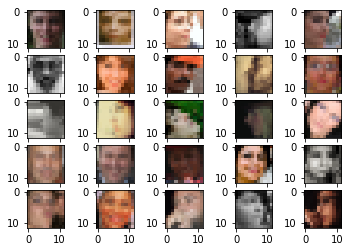

In [10]:
fig, axarr = plt.subplots(5, 5)
for ax, idx in zip(axarr.flatten(), np.random.randint(0, data.shape[0], 25)):
    ax.imshow(np.moveaxis(data[idx], 0, 2))

In [11]:
data -= data.mean(axis = (0,2,3)).reshape(1, 3, 1, 1)
data /= data.std(axis = (0,2,3)).reshape(1, 3, 1, 1)

In [12]:
person_images_df = pd.read_csv('./EX2_data/VOCdevkit/VOC2007/ImageSets/Main/person_trainval.txt', sep = '\s+', header=None,  dtype={0: str})

In [13]:
person_images_df = person_images_df[person_images_df[1] == -1]

In [14]:
person_images_df.shape

(2916, 2)

In [15]:
num_crop = 10
false_imgs = []
for img_num in person_images_df[0]:
    img = imread('./EX2_data/VOCdevkit/VOC2007/JPEGImages/%s.jpg' %img_num)
    for i, j in zip(np.random.randint(0, img.shape[0] - L, num_crop),
                    np.random.randint(0, img.shape[1] - W, num_crop)):
        crop_img = img[i:i+L, j:j+W, :].copy()
        false_imgs.append(crop_img)
false_imgs = np.moveaxis(np.stack(false_imgs), 3, 1)

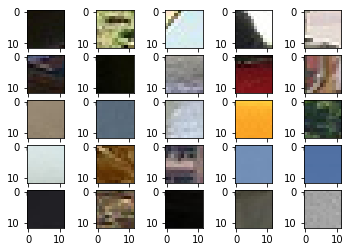

In [16]:
fig, axarr = plt.subplots(5, 5)
for ax, idx in zip(axarr.flatten(), np.random.randint(0, false_imgs.shape[0], 25)):
    ax.imshow(np.moveaxis(false_imgs[idx], 0, 2))

In [17]:
false_imgs = false_imgs.astype(np.float64)
false_imgs -= false_imgs.mean(axis = (0,2,3)).reshape(1, 3, 1, 1)
false_imgs /= false_imgs.std(axis = (0,2,3)).reshape(1, 3, 1, 1)

In [18]:
X = np.concatenate((data, false_imgs))
Y = np.concatenate((np.ones(data.shape[0]), np.zeros(false_imgs.shape[0])))
X.shape, Y.shape

((53545, 3, 12, 12), (53545,))

In [19]:
conv_12_dim = 16
conv_12_size = 3
conv_12_stride = 1
conv_12_pad = 1
max_pool_size = 3
max_pool_stride = 2
max_pool_pad=1
fc_12_size = 16

val_precenteg = 0.15
BATCH_SIZE = 128
print_every = 10

## **Q1**

In [20]:
tw_net = nn.Sequential(nn.Conv2d(C, conv_12_dim, conv_12_size, padding=conv_12_pad),
                           nn.MaxPool2d(kernel_size=max_pool_size, stride=max_pool_stride, padding=max_pool_pad),
                           nn.ReLU(),
                           View(),
                           nn.Linear((L // 2) ** 2 * conv_12_dim, fc_12_size),
                           nn.ReLU(),
                           nn.Linear(fc_12_size, output_dim)).to(device=device)

In [21]:
mask = np.arange(0, X.shape[0])
np.random.shuffle(mask)
val_mask = mask[:int(X.shape[0] * val_precenteg)]
train_mask = mask[int(X.shape[0] * val_precenteg):]

X_val = torch.FloatTensor(X[val_mask]).to(device=device)
X_train = torch.FloatTensor(X[train_mask]).to(device=device)
Y_val = torch.LongTensor(Y[val_mask]).to(device=device)
Y_train = torch.LongTensor(Y[train_mask]).to(device=device)

train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)
loader_train = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(X_train.shape[0])))

In [22]:
conv_train_loss_lst, conv_val_loss_lst = [], []

loss_fn = F.cross_entropy

optimizer = optim.Adam(tw_net.parameters(), lr=1e-3)

# Decay LR by a factor of 0.5 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=1.0)

In [23]:
loss = train(tw_net, 1, loader_train, loss_fn, optimizer, exp_lr_scheduler, X_val, Y_val)

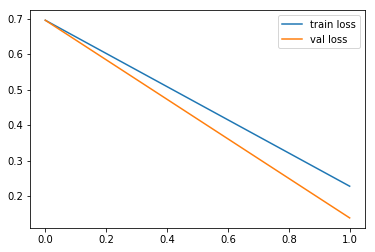

In [24]:
plt.plot(np.arange(len(loss[0])), loss[0], label='train loss')
plt.plot(np.arange(len(loss[1])), loss[1], label='val loss')
plt.legend()
plt.show()

In [25]:
y_pred = torch.argmax(tw_net(X_val), 1)
acuarcy = torch.sum(y_pred == Y_val).item() / y_pred.shape[0]
train_pred = torch.argmax(tw_net(X_train), 1)
train_acuarcy = torch.sum(train_pred == Y_train).item() / train_pred.shape[0]
print('train acuarcy: %f, val acuarcy: %f' %(train_acuarcy, acuarcy))

mask = np.arange(X_val.shape[0])
np.random.shuffle(mask)
display = X_val[mask[:25]]
y_pred = y_pred[mask[:25]]

train acuarcy: 0.957947, val acuarcy: 0.954551


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

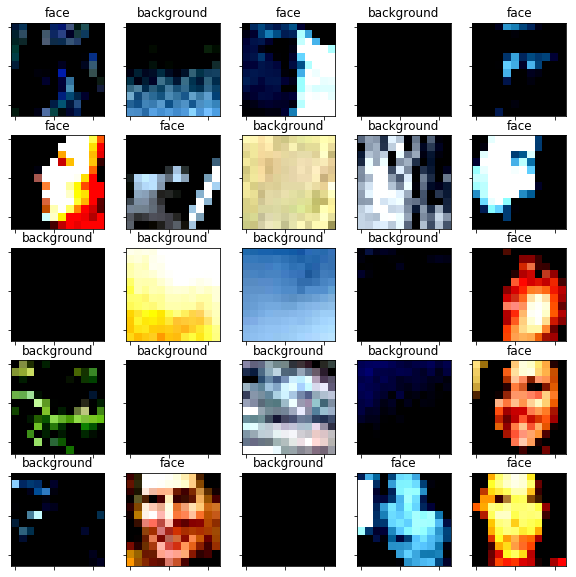

In [26]:
display = display.numpy()
y_pred = y_pred.numpy()
fig, axarr = plt.subplots(5, 5, figsize=(10,10))
for ax, idx in zip(axarr.flatten(), np.arange(25)):
    ax.imshow(np.moveaxis(display[idx], 0, 2))
    if y_pred[idx] == 0:
        title = 'background'
    else:
        title = 'face'
    ax.set_title(title)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()

## **Q2**

In [27]:
class print_shape(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x

In [28]:
tw_net_fcn = nn.Sequential(nn.Conv2d(C, conv_12_dim, conv_12_size, padding=conv_12_pad),
                           nn.ZeroPad2d((0, 1, 0, 1)),
                           nn.MaxPool2d(kernel_size=max_pool_size, stride=max_pool_stride),
                           nn.ReLU(),
                           nn.Conv2d(in_channels=conv_12_dim, out_channels=fc_12_size, kernel_size=(L // 2)),
                           nn.ReLU(),
                           nn.Conv2d(in_channels=fc_12_size, out_channels=output_dim, kernel_size=1),
                           )

In [29]:
mask = np.arange(0, X.shape[0])
np.random.shuffle(mask)
val_mask = mask[:int(X.shape[0] * val_precenteg)]
train_mask = mask[int(X.shape[0] * val_precenteg):]

X_val = torch.FloatTensor(X[val_mask]).to(device=device)
X_train = torch.FloatTensor(X[train_mask]).to(device=device)
Y_val = torch.LongTensor(Y[val_mask]).to(device=device).view(-1, 1, 1)
Y_train = torch.LongTensor(Y[train_mask]).to(device=device).view(-1, 1, 1)

train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)
loader_train = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(X_train.shape[0])))

In [30]:
conv_train_loss_lst, conv_val_loss_lst = [], []

loss_fn = F.cross_entropy

optimizer = optim.Adam(tw_net_fcn.parameters(), lr=1e-3)

# Decay LR by a factor of 0.5 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=1.0)

In [31]:
loss = train(tw_net_fcn, 30, loader_train, loss_fn, optimizer, exp_lr_scheduler, X_val, Y_val)

ephoc 10, loss = 0.0475  val_loss = 0.0513
ephoc 20, loss = 0.0318  val_loss = 0.0443
ephoc 30, loss = 0.0244  val_loss = 0.0514


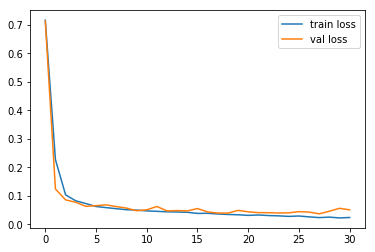

In [32]:
plt.plot(np.arange(len(loss[0])), loss[0], label='train loss')
plt.plot(np.arange(len(loss[1])), loss[1], label='val loss')
plt.legend()
plt.show()

In [33]:
y_pred = torch.argmax(tw_net_fcn(X_val), 1)
acuarcy = torch.sum(y_pred == Y_val).item() / y_pred.shape[0]
train_pred = torch.argmax(tw_net_fcn(X_train), 1)
train_acuarcy = torch.sum(train_pred == Y_train).item() / train_pred.shape[0]
print('train acuarcy: %f, val acuarcy: %f' %(train_acuarcy, acuarcy))

train acuarcy: 0.989146, val acuarcy: 0.984062


In [36]:
home_dir = './EX2_data/fddb/'
with open(home_dir + 'FDDB-folds/FDDB-fold-01.txt') as f:
    paths = f.readlines()
imgs = []
for path in paths:
    img = imread(home_dir + 'images/' + path[:-1] + '.jpg')
    if len(img.shape) < 3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = img.astype(np.float64)
    img -= img.mean(axis=(0,1)).reshape(1, 1, 3)
    img /= img.std(axis=(0,1)).reshape(1, 1, 3)
    imgs.append(np.moveaxis(img, 2, 0))

In [37]:
imgs[3].shape

(3, 450, 370)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

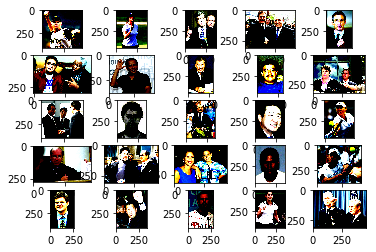

In [38]:
fig, axarr = plt.subplots(5, 5)
for ax, idx in zip(axarr.flatten(), np.random.randint(0, len(imgs), 25)):
    ax.imshow(np.moveaxis(imgs[idx], 0, 2))

In [39]:
tw_net_fcn.eval()

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ZeroPad2d(padding=(0, 1, 0, 1), value=0)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): ReLU()
  (4): Conv2d(16, 16, kernel_size=(6, 6), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1))
)

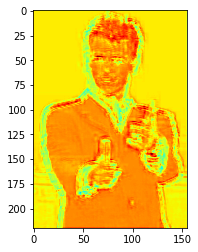

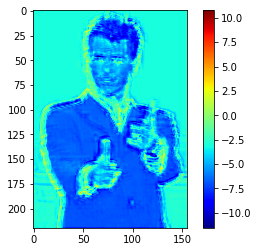

In [40]:
t = torch.FloatTensor(imgs[44])
t = t.view(1, *t.shape)
t_img = tw_net_fcn(t).detach().numpy()
plt.imshow(t_img[0,0,:,:], cmap='jet', vmin=np.min(t_img), vmax=np.max(t_img))
plt.figure()
plt.imshow(t_img[0,1,:,:], cmap='jet', vmin=np.min(t_img), vmax=np.max(t_img))
plt.colorbar()

In [41]:
pyramid = tuple(pyramid_gaussian(np.moveaxis(imgs[0], 0, 2), downscale=2, multichannel=True, max_layer=5))

In [42]:
pyramid[3].shape

(54, 57, 3)

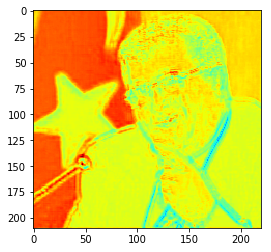

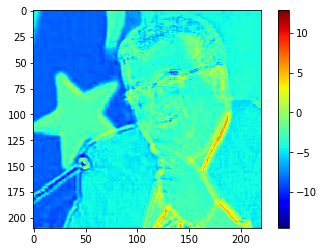

In [43]:
t = torch.FloatTensor(np.moveaxis(pyramid[0], 2, 0))
t = t.view(1, *t.shape)
t_img = tw_net_fcn(t).detach().numpy()
plt.imshow(t_img[0,0,:,:], cmap='jet', vmin=np.min(t_img), vmax=np.max(t_img))
plt.figure()
plt.imshow(t_img[0,1,:,:], cmap='jet', vmin=np.min(t_img), vmax=np.max(t_img))
plt.colorbar()

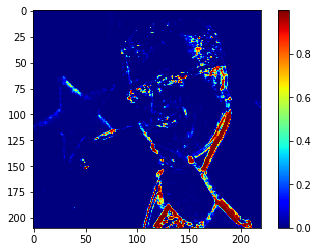

In [44]:
sm_t = np.exp(t_img[0,1,:,:]) / np.sum(np.exp(t_img[:,:,:,:]), axis=(0,1))
plt.imshow(sm_t, cmap='jet')
plt.colorbar()


In [45]:
sm_t.shape, t.shape

((210, 220), torch.Size([1, 3, 431, 450]))

In [46]:
imgs[0].shape

(3, 431, 450)

In [139]:
def face_rec_12(img, threshold=0.5, iou_threshold=0.5):
    pyramid = tuple(pyramid_gaussian(np.moveaxis(img, 0, 2), downscale=2, multichannel=True, max_layer=4))
    predicted = [tw_net_fcn(torch.FloatTensor(np.moveaxis(pyr.reshape(1, *pyr.shape), 3, 1))) for pyr in pyramid]
    pyramid_sfm = [F.softmax(pred, dim=1) for pred in predicted]
    pyramid_sfm = [pred[0, 1].detach().numpy() for pred in pyramid_sfm]
    
        
    for pred in pyramid_sfm:
        pred[pred < threshold] = 0.0
    
    X, Y = np.meshgrid(np.abs(np.arange(-10, 12, 2)), np.abs(np.arange(-10, 12, 2)))
    iou = ((12 - X) * (12 - Y)) / (2 * 12**2 - ((12 - X) * (12 - Y)))
    bgier_then_thres = iou >= iou_threshold
    iou[bgier_then_thres] = 0.0
    iou[np.logical_not(bgier_then_thres)] = 1.0
    iou[5, 5] = 1.0
    plt.figure()
    plt.imshow(iou)
    plt.colorbar()
    final_pred = []
    for pred in pyramid_sfm:
        pred = np.pad(pred, (5,5), 'constant')
        i = 0
        cond = True
        epsilon = 1e-10
        while cond:
            ind = np.flip(np.argsort(pred.flatten()))[i]
            ind = np.unravel_index(ind, pred.shape)
            if pred[ind] < epsilon:
                break
            k, l = ind[0], ind[1]
#             plt.figure()
#             plt.imshow(pred)
#             plt.title('%d, %d' %(k, l))
            pred[k-5: k + 6, l - 5: l + 6] *= iou
#             plt.figure()
#             plt.imshow(pred)
#             plt.title('%d, %d' %(k, l))
            i += 1
        final_pred.append(pred[5:-5, 5:-5])
    
    for g in final_pred:
        plt.figure()
        plt.imshow(g, cmap='jet')
        plt.colorbar()

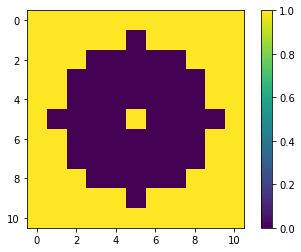

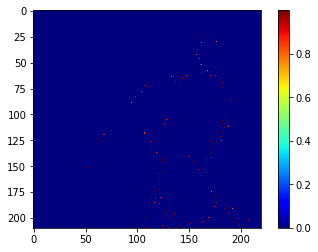

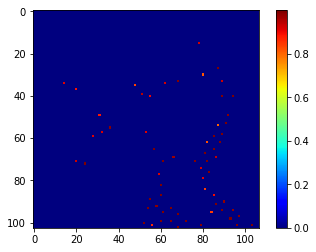

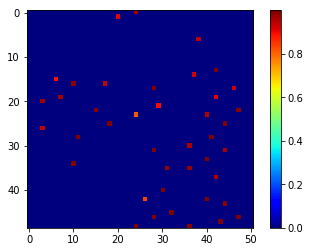

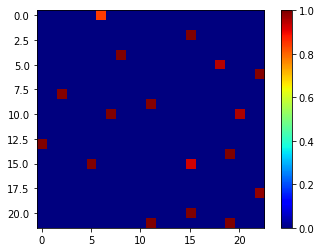

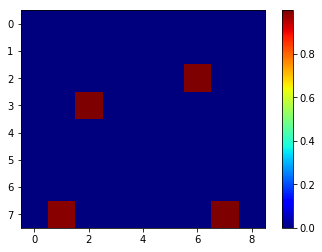

In [141]:
face_rec_12(imgs[0], threshold=0.8, iou_threshold=0.2)

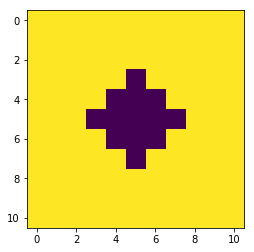

In [60]:
X, Y = np.meshgrid(np.abs(np.arange(-10, 12, 2)), np.abs(np.arange(-10, 12, 2)))
iou = ((12 - X) * (12 - Y)) / (2 * 12**2 - ((12 - X) * (12 - Y)))
bgier_then_thres = iou >= 0.5
iou[bgier_then_thres] = 0.0
iou[np.logical_not(bgier_then_thres)] = 1.0
plt.imshow(iou)

In [78]:
idx = np.flip(np.argsort(sm_t.flatten()))[0]
idx = np.unravel_index(idx, sm_t.shape)
sm_t[idx]

0.9999994

In [80]:
a = np.ones((3,3))

In [97]:
np.arange(10)[0:2]

array([0, 1])